# ML_25M Classic ML

In [1]:
import os
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

seed = 42
np.random.seed(seed)
random.seed(seed)
df = pd.read_csv('dataset.csv')


## Data Preprocessing

In [2]:
X = df.drop('rating', axis=1)
Y = df['rating']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
pca = PCA()
pca.fit(X_train)

PCA()

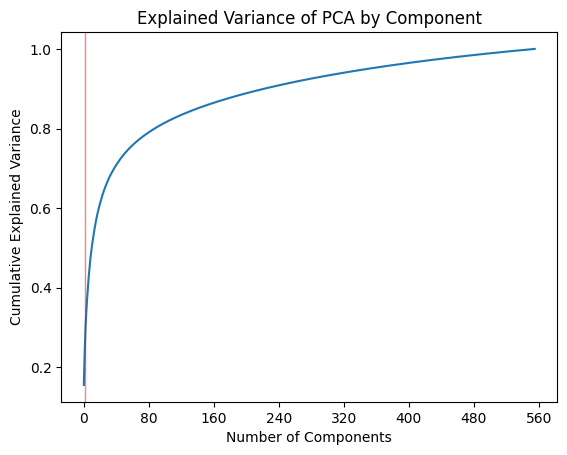

In [11]:
def var_explained():
    import numpy as np
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axvline(x=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Explained Variance of PCA by Component')
    show()

var_explained()

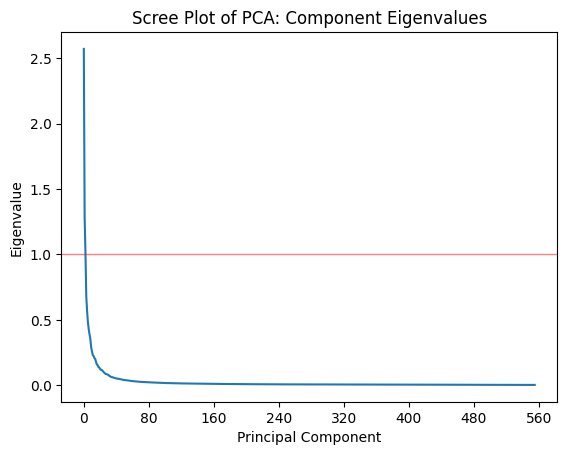

In [14]:
def scree_plot():
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(pca.explained_variance_)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Scree Plot of PCA: Component Eigenvalues')
    show()
    
scree_plot()

In [15]:
# PCA
pca = PCA(n_components=pca.n_components_)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [16]:
print(f'Number of training samples: {X_train.shape}')
print(f'Number of testing samples: {X_test.shape}')
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2'])


Number of training samples: (11052, 556)
Number of testing samples: (2764, 556)


# Models

## Support Vector Regression

In [ ]:
# SVR with Bayesian Optimization
def svr_cv(C, gamma, epsilon):
    val = cross_val_score(SVR(C=C, gamma=gamma, epsilon=epsilon), X_train, Y_train, scoring="neg_mean_squared_error", cv=5)
    return np.mean(val)

# Bounded region of parameter space
pbounds = {'C': (0.1, 100), 'gamma': (0.0001, 0.1), 'epsilon': (0.1, 1)}

optimizer = BayesianOptimization(
    f=svr_cv,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=10,
)   

print(optimizer.max{'params'})

# SVR
svr = SVR(C=optimizer.max['params']['C'], gamma=optimizer.max['params']['gamma'], epsilon=optimizer.max['params']['epsilon'])
svr.fit(X_train, Y_train)
Y_pred = svr.predict(X_test)

# Evaluate the model
mse = np.mean((Y_pred - Y_test)**2)
rmse = np.sqrt(mse)
r2 = svr.score(X_test, Y_test)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

results = df.concat([results, pd.DataFrame({'Model': 'SVR', 'MSE': mse, 'RMSE': rmse, 'R2': r2}, index=[0])], ignore_index=True)

## Random Forest Regressor

In [ ]:
# Random Forest Regressor

best_n = 0
best_mse = float('inf')

for n in range(50, 100):
    print("Number of trees: {}".format(n), end='\r')
    rfr = RandomForestRegressor(n_estimators=n, random_state=seed)
    rfr.fit(X_train, Y_train)
    rfr_pred = rfr.predict(X_test)
    mse = np.mean((rfr_pred - Y_test) ** 2)
    if mse < best_mse:
        best_mse = mse
        best_n = n

print(f'\n\nBest number of trees: {best_n}')
print(f'Best MSE: {best_mse}')

rfr = RandomForestRegressor(n_estimators=best_n, random_state=seed)
rfr.fit(X_train, Y_train)
rfr_pred = rfr.predict(X_test)

# MSE and RMSE
mse = np.mean((rfr_pred - Y_test) ** 2)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# R2
r2 = rfr.score(X_test, Y_test)
print(f'R2: {r2}')

results = pd.concat([results, pd.DataFrame({'Model': 'Random Forest Regressor', 'MSE': mse, 'RMSE': rmse, 'R2': r2}, index=[0])], ignore_index=True)
print(results)

## Linear Regressor

In [17]:
#linear regression
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

In [18]:
# Evaluate the model
mse = mean_squared_error(Y_pred,Y_test)

# Accuracy
r2 = r2_score(Y_test, Y_pred)

print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 0.006358792492629835
R2: 0.9713136439361892


## Ridge Regression

In [19]:
# ridge regression
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, Y_train)
ridge_pred = ridge.predict(X_test)

# Evaluate the model
mse = mean_squared_error(ridge_pred,Y_test)

# Accuracy
r2 = r2_score(Y_test, ridge_pred)

print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 0.006357588911846219
R2: 0.9713190736379683


## Lasso Regressor

In [20]:
# lasso regression
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.00001) # higher value of alpha results in a more sparse model. 
lasso.fit(X_train, Y_train)
lasso_pred = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(lasso_pred,Y_test)

# Accuracy
r2 = r2_score(Y_test, lasso_pred)

print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 0.006333744191920816
R2: 0.9714266440810697


## Elastic Net

In [21]:
# elastic net
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(alpha=0.00001, l1_ratio=0.5)
elasticnet.fit(X_train, Y_train)
elastic_pred = elasticnet.predict(X_test)

# Evaluate the model
mse = mean_squared_error(elastic_pred,Y_test)

# Accuracy
r2 = r2_score(Y_test, elastic_pred)

print(f'MSE: {mse}')

print(f'R2: {r2}')

MSE: 0.006343437158385791
R2: 0.9713829162997887
